# Bond Dataset
The bonds dataset contains 4008 observations of the returns of government bonds, alongside 11 additional predictor variables in the dataset sourced from various financial indices, including USD value, crude oil prices and US Equity indices.

In [1]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
from numpy import linalg as lin
import seaborn as sns
import pandas as pd

# Import data
my_data = genfromtxt('../Data/bond.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:]
names = ["TSY SHORT YLD","TSY LONG YLD","CORP YLD","JUNK YLD","BOND FUT VOL",
         "STK DX TOT RET","STK IDX VOL","ROW STK TOT RET","CRUDE","CRUDE VOL",
         "USD","TSY FUT NXT DAY RET"]

## Dataset Features

The variable to be forecast is the next-day government bond future return (**TSY FUT NXT DAY RET** in the legend). In general, I will refer to this as the target variable. Visually looking at the time series, we see that the process is roughly zero mean, with a time dependent variance, but otherwise there are not many striking features (to me).

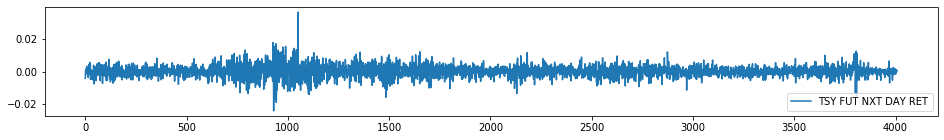

In [2]:
# Plot our target
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,11]) 
plt.legend( [names[11]], loc="lower right")
plt.show()

The additional predictors included in this data set are
- **TSY SHORT YLD** short term treasury yield
- **TSY LONG YLD** long term treasury yield
- **CORP YLD** long term investment grade yield
- **JUNK YLD** junk bond yield
- **BOND FUT VOL** bond future volatility forecast
- **STK DX TOT RET** US Equity total return index
- **STK IDX VOL** US Equity volatility forecast
- **ROW STK TOT RET** World ex-US Equity total return index
- **CRUDE** WTI crude oil price
- **CRUDE VOL** WTI crude oil volatility forecast
- **USD** dollar index

Each predictor has a noticeably different scale, so to visualize each signal we must plot them on separate axes. I don't have many comments on these signals, but I will note that the TSY SHORT YLD graph features an outlier at sample index 956, which we may chose to ignore or to modify dependent on the method we employ. 

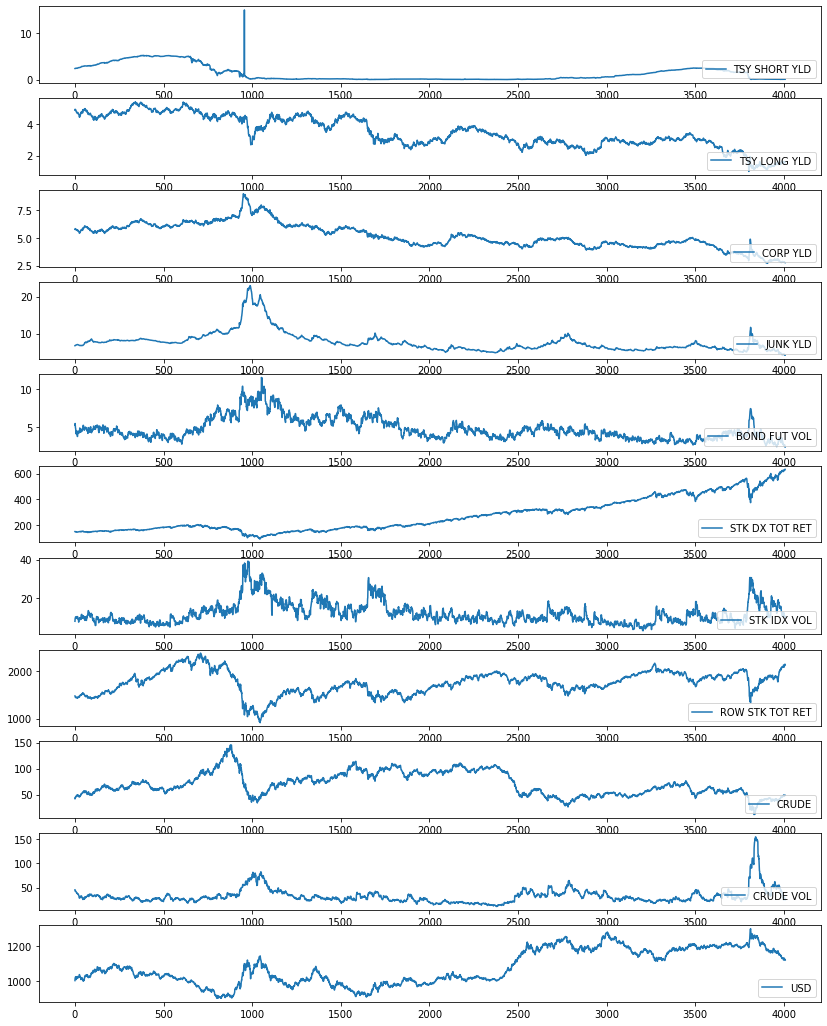

In [3]:
# Plot our target variable
plt.figure(figsize=(14, 20))
for k in range(0,my_data.shape[1]-1):
    plt.subplot(my_data.shape[1],1,k+1)
    plt.plot(my_data[:,k]) 
    plt.legend( [names[k]], loc="lower right")
plt.show()

## Marginal Distributions
A popular technique to visualize the correlations between factors in a multidimensional dataset is to use a pair-pair plot, where each row/column is a scatterplot or histogram to visualize the marginal distribution of either a feature or a pair of features from the higher dimensional sample distribution. From this form, we can already learn a great deal about trends in the data. 

There are many features in this data set, so the resulting plots are a bit small. Also, the outlier in the TSY SHORT YLD time series will skew out plot axes, so I've manually smoothed over this data point it for these analyses. Outside of this, the pairplot is difficult to analyze. The resulting marginal distributions have some apparent structure, but the shapes are very irregular and difficult to interpret. Most of the distributions appear to be two-dimensional, so at the very least it's not immediately obvious that these predictors contain redundant information.

One thing that we can note is that the target is qualitative different than its peers. All of the plots with the target variable exhibit a certain independecne from the other features. Of course, this doesn't mean that the true 14 dimension distribution doesn't have a simpler structure.



C:\Users\kurtb\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kurtb\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


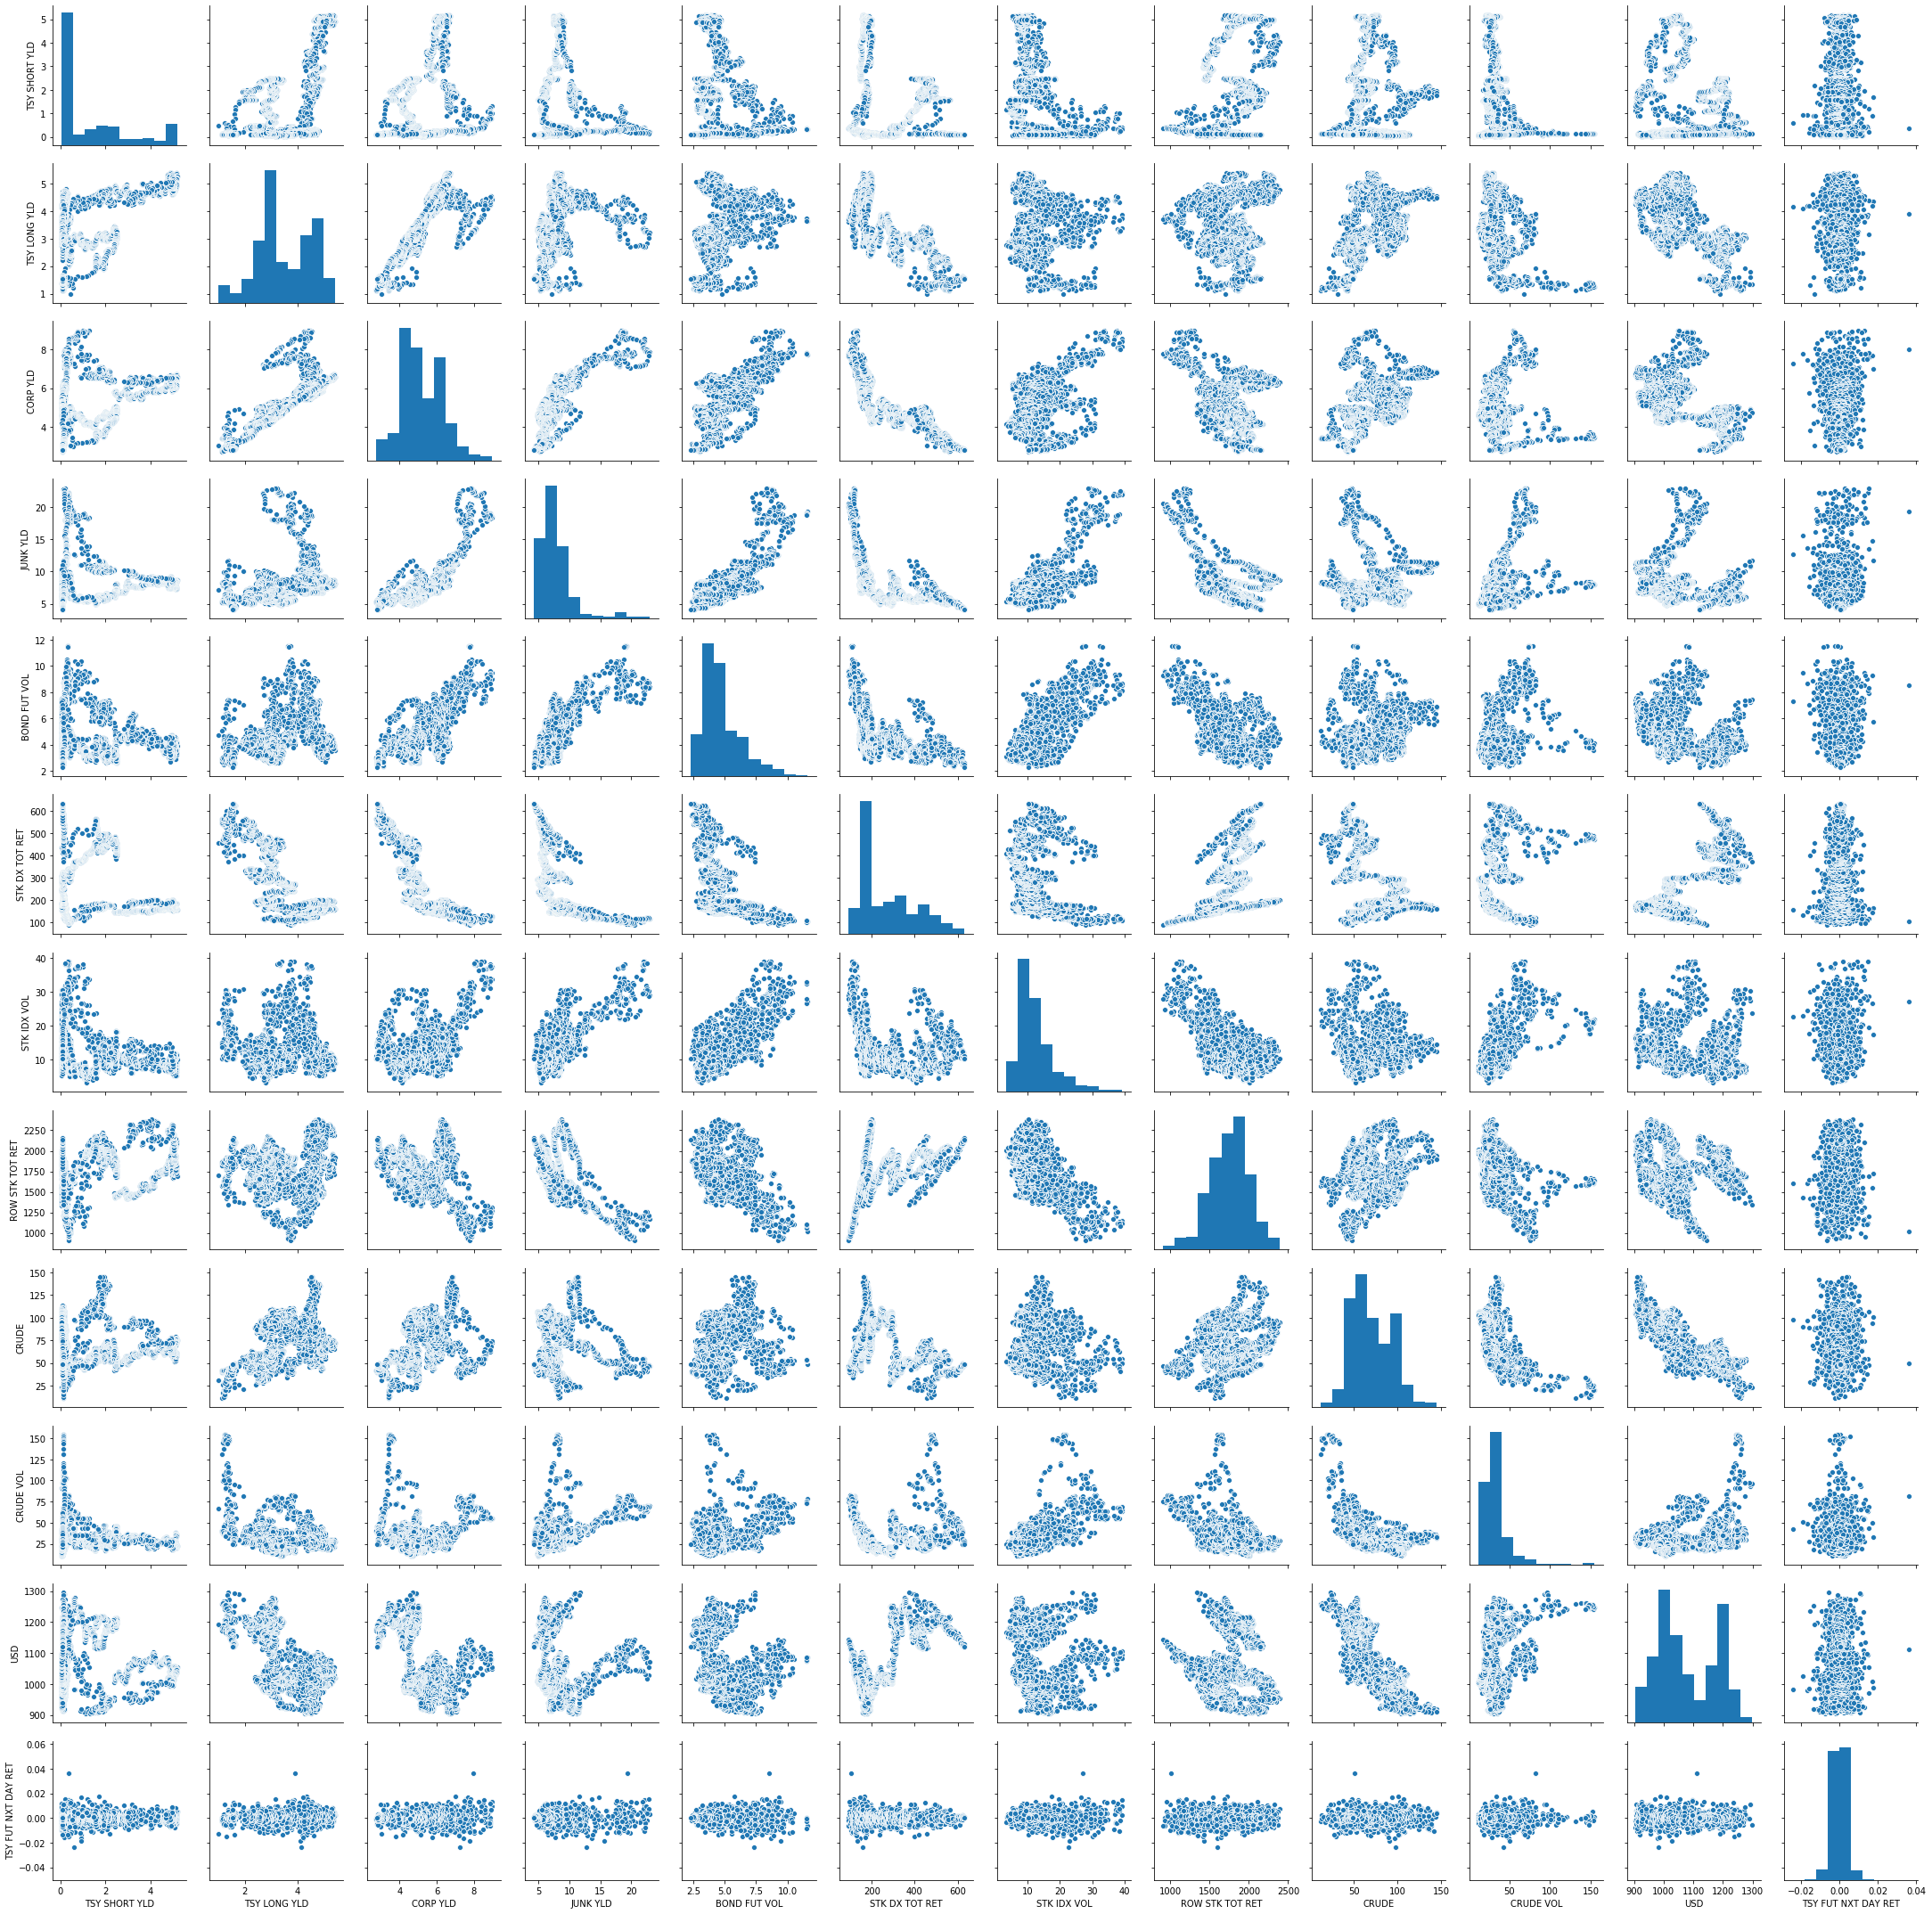

In [4]:
# Smooth over the outlier point
my_data[956,0] = 0.5*(my_data[955,0] + my_data[957,0])

# Produce the marginal distributions
my_frame = pd.DataFrame(my_data,columns=names)
sns.pairplot(my_frame, dropna=True)

## Data Imputation
Unlike the natural gas dataset, there are several missing values in the time series here. Thus, it will be worthwhile to perform data imputation in a principled way instead of ignoring the missing values altogether.

In [20]:
from sktime.transformations.series.impute import Imputer

transformer = Imputer(method="drift")
my_data = transformer.fit_transform(my_data)

ModuleNotFoundError: No module named 'sktime'

## Detrending
The bond dataset does not feature any clear seasonality, but the trends in the dataset may be desirable to remove.

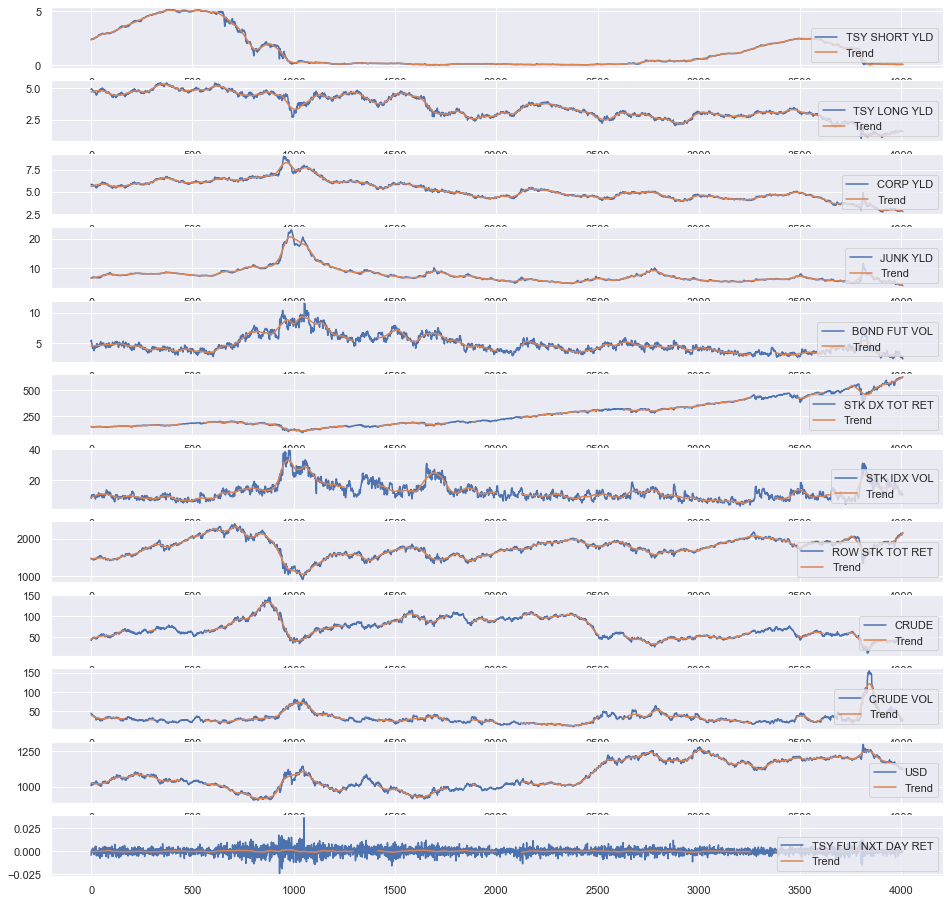

In [18]:
# Filter the data
window_length = 91
polyorder = 2
datatrend = savgol_filter(my_data, window_length, polyorder, axis=0)

# Produce a time variable
weeks = np.arange(0,datatrend.shape[0])

# Plot the trend fits
plt.figure(figsize=(16, 16))
for k in range(0,my_data.shape[1]):
    plt.subplot(my_data.shape[1],1,k+1)
    plt.plot(weeks, my_data[:,k],weeks, datatrend[:,k])
    plt.legend([names[k],'Trend'], loc='lower right')
plt.show()

To detrend the data then, we simply subtract each trend from it's associated signal.

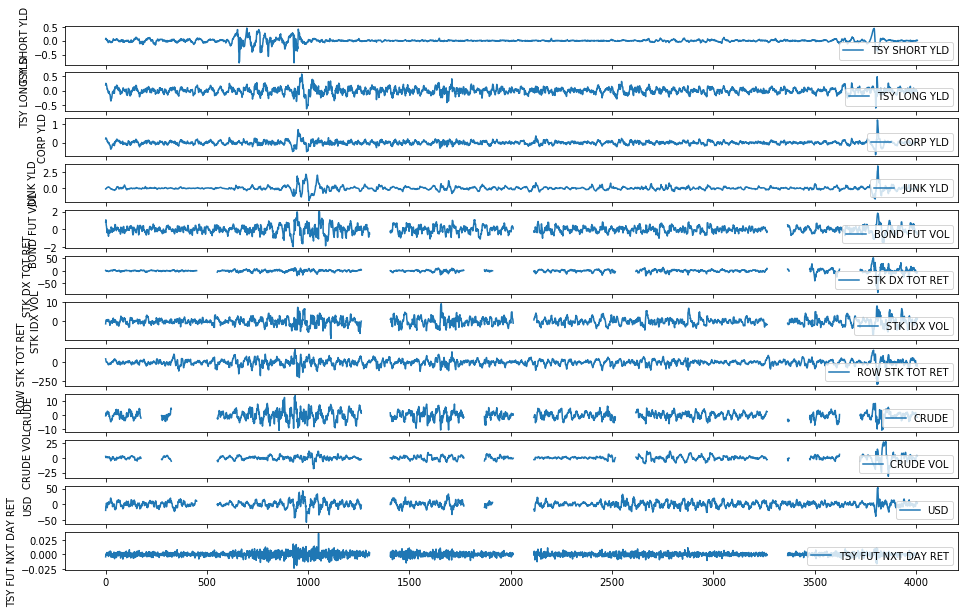

In [13]:
# Remove the trends
detrended_data = my_data - datatrend

# Plot the trend fits
plt.figure(figsize=(16, 10))
for k in range(0,my_data.shape[1]):
    plt.subplot(my_data.shape[1],1,k+1)
    plt.plot(weeks, detrended_data[:,k])
    plt.legend([names[k]], loc='lower right')
plt.show()

Finally, we may consider the pairplot again for each pair of detrended signals. We observe that after detrending, all of our marginal distributions are roughly zero-mean.

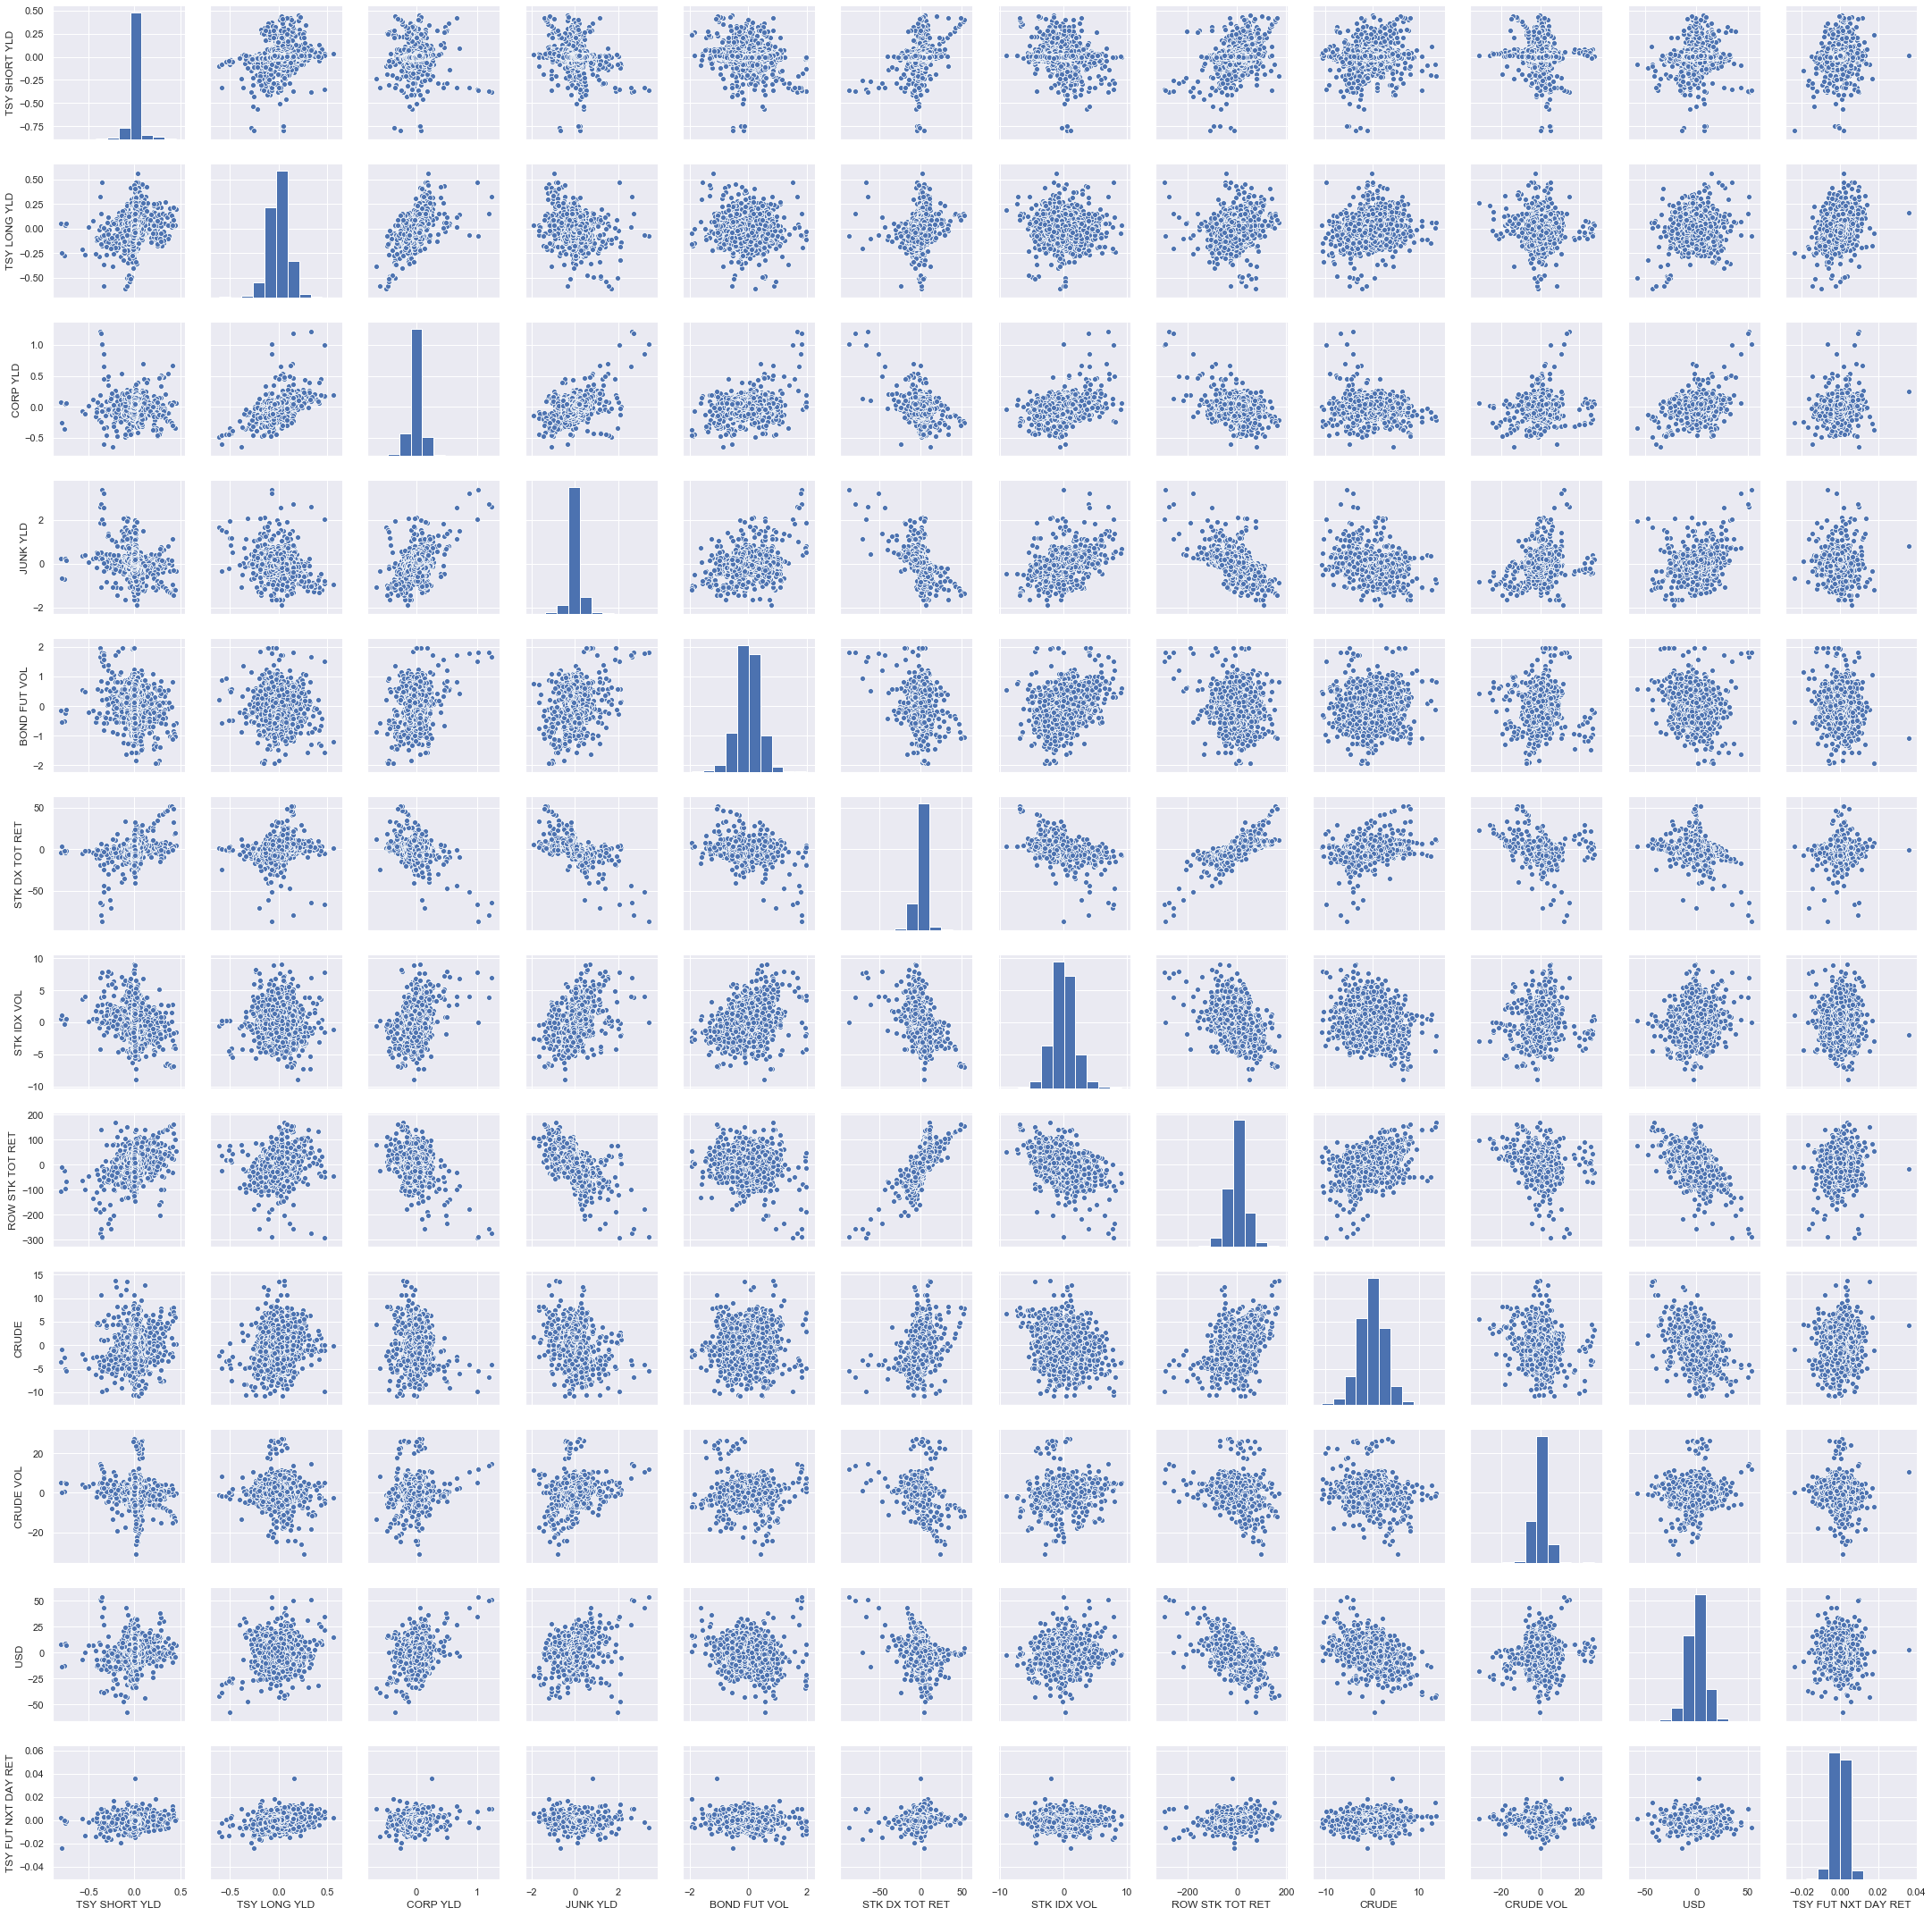

In [14]:
my_frame = pd.DataFrame(detrended_data,columns=names)
sns.set(rc={'figure.figsize':(7,7)})
sns.pairplot(my_frame, dropna=True)

## Linear correlation
Working with the detrended data now, we can ask questions about the result zero-mean processes. Are they normal? Are they correlated? In the pairplots above, most predictors do not have a linear correlation with the target. However, we observe some correlation between the airport temperatures, even after detrending. This indicates that we may consider some feature reduction if we apply a model, such as linear models, to this data set. In particular, principle component analysis (PCA) will be appropriate for any linear model we select.

Here, we show the resulting correlation plot given the above detrended pairplots. Note that this correlation is all instantaneous in time. Generalized cross-correlation may consider lags in time between signals, which will detect interactions between factors with a propagation delay.

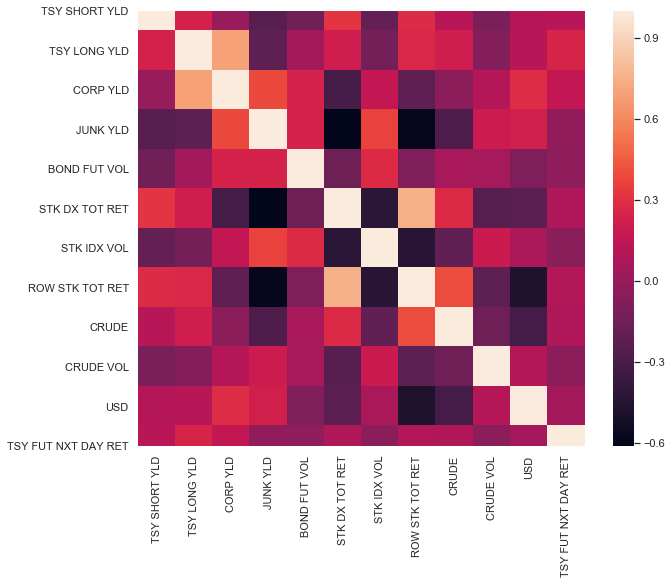

In [19]:
my_frame = pd.DataFrame(detrended_data,columns=names)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(my_frame.corr())